<a href="https://colab.research.google.com/github/tbone30/DS-3001/blob/main/DS_3001_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PRE-ANALYSIS PLOTS

In [2]:
import pandas as pd
df = pd.read_csv('dataset.csv')
df.describe()
print(df.columns)

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

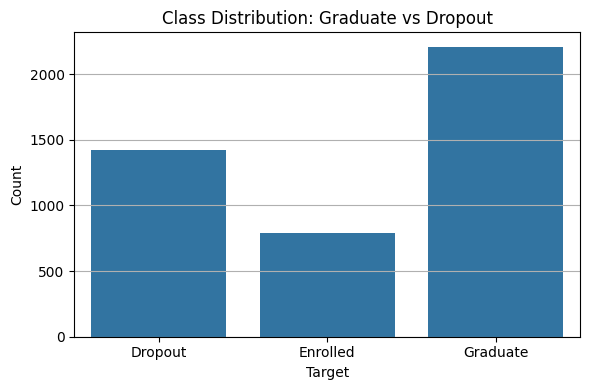

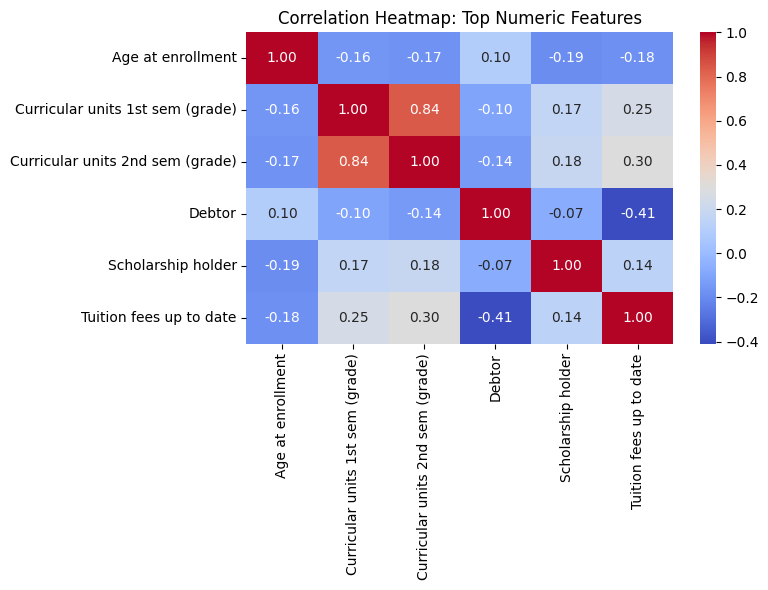

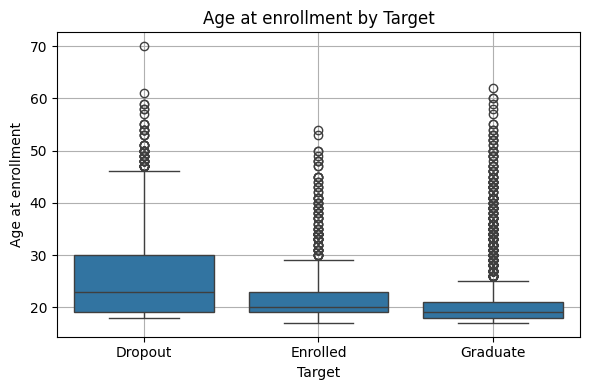

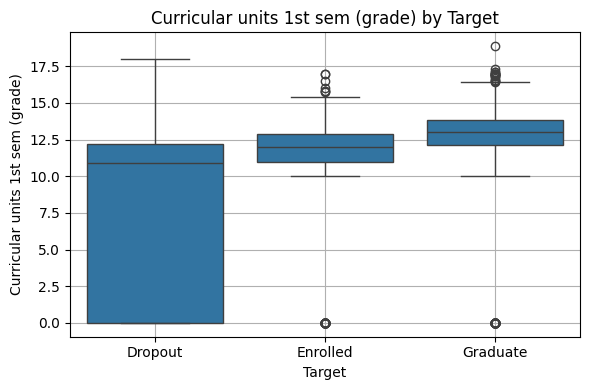

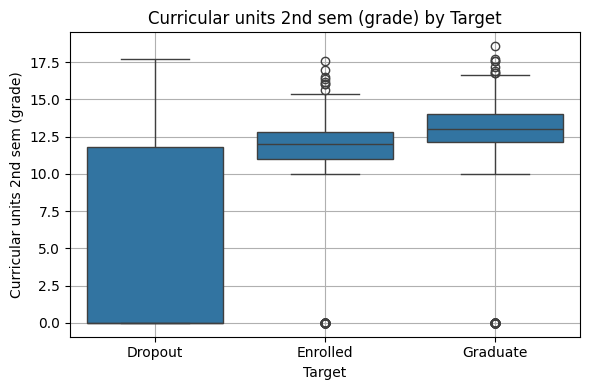

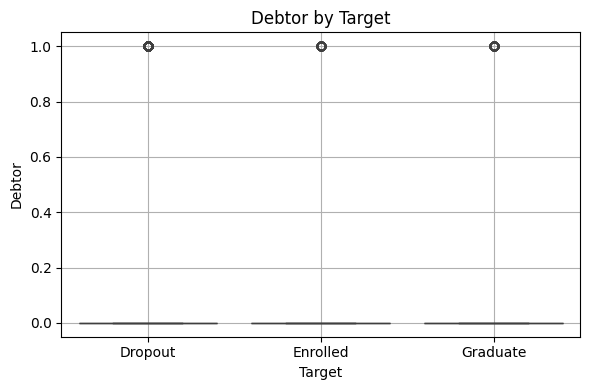

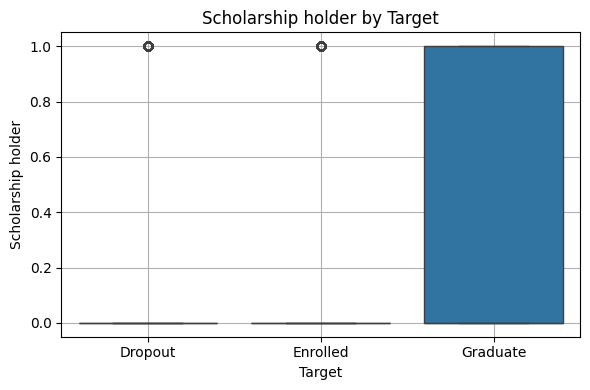

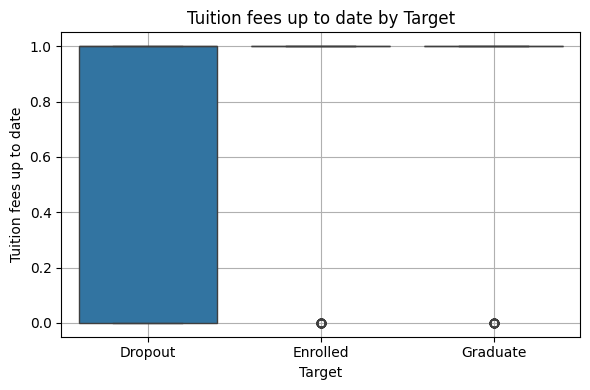

Redundant Features (corr > 0.9): []


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("dataset.csv")

# Convert object columns to categorical
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].astype('category')

# Define the top 6 most important features
top_features = [
    'Age at enrollment',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Debtor',
    'Scholarship holder',
    'Tuition fees up to date'
]

# 1. Target class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df)
plt.title("Class Distribution: Graduate vs Dropout")
plt.xlabel("Target")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Correlation heatmap (filtered to top numeric features)
numeric_features = df[top_features].select_dtypes(include=[np.number])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Top Numeric Features")
plt.tight_layout()
plt.show()

# 3. Boxplots for top numeric features by target
for feature in numeric_features.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Target', y=feature)
    plt.title(f"{feature} by Target")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Countplots for categorical top features by target
categorical_top_features = [f for f in top_features if f in categorical_cols]
for feature in categorical_top_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feature, hue='Target')
    plt.title(f"{feature} by Target")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 5. Redundancy check (numeric correlation > 0.9)
corr_matrix = numeric_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
redundant_features = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Redundant Features (corr > 0.9):", redundant_features)


MODEL 1: KNN

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model_pipeline, X_test, y_test, title="Confusion Matrix"):
    # Predict
    y_pred = model_pipeline.predict(X_test)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model_pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score

def build_knn_for_student_data(data):
    print("Building KNN Classifier for Dropout/Graduation Prediction...")

    # Separate target
    target_col = 'Target'
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

    # Preprocessing for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Create the KNN pipeline
    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='auto', p=2))
    ])

    # Hyperparameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'leaf_size': [10, 20, 30, 40, 50],
    }

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Grid Search
    grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', verbose=2)
    grid_search.fit(X_train, y_train)

    # Results
    print("\nBest Parameters:")
    print(grid_search.best_params_)
    # Train the model
    knn_pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = knn_pipeline.predict(X_test)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    print("\nKNN Classification Results:")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(knn_pipeline, X_test, y_test, title="KNN Confusion Matrix")

    return knn_pipeline

build_knn_for_student_data(df)

Building KNN Classifier for Dropout/Graduation Prediction...
Fitting 5 folds for each of 28 candidates, totalling 140 fits


ValueError: Invalid parameter 'n_neighbors' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Marital status',
                                                   'Application mode',
                                                   'Application order',
                                                   'Course',
                                                   'Daytime/evening attendance',
                                                   'Previous qualification',
                                                   'Nacionality',
                                                   "Mother's qualification",
                                                   "Father's qualification",
                                                   "Mother's occupation",
                                                   "Father...
                                                   'Curricular units 2nd sem '
                                                   '(credited)',
                                                   'Curricular units 2nd sem '
                                                   '(enrolled)',
                                                   'Curricular units 2nd sem '
                                                   '(evaluations)',
                                                   'Curricular units 2nd sem '
                                                   '(approved)',
                                                   'Curricular units 2nd sem '
                                                   '(grade)', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', KNeighborsClassifier(metric=''))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

MODEL 2: RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score
import numpy as np

def gridsearch_rf_for_student_data(data):
    print("Running GridSearchCV for Random Forest...")

    # Setup
    target_col = 'Target'
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Column types
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    # Pipeline
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])

    # Hyperparameter grid
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Grid Search
    grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', verbose=2)
    grid_search.fit(X_train, y_train)

    # Results
    print("\nBest Parameters:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"\nWeighted F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return best_model


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def build_rf_for_student_data(data):
    print("Building Random Forest Classifier for Dropout/Graduation Prediction...")

    # Target
    target_col = 'Target'
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Auto-detect feature types
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())  # optional but keeps things comparable
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    # Full pipeline
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            class_weight='balanced',
            random_state=42
        ))
    ])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Fit
    rf_pipeline.fit(X_train, y_train)

    # Predict
    y_pred = rf_pipeline.predict(X_test)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    print("\nRandom Forest Classification Results:")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(rf_pipeline, X_test, y_test, title="Random Forest Confusion Matrix")

    return rf_pipeline


MODEL 3: K-MEANS CLUSTERING

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

def elbow_plot_for_kmeans(data, max_k=10):
    print("Generating elbow plot for KMeans clustering...")

    # Drop target if it exists
    data_no_target = data.drop(columns=['Target'], errors='ignore')

    # Separate numerical and categorical columns
    numerical_cols = data_no_target.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = data_no_target.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    # Preprocess data
    X_processed = preprocessor.fit_transform(data_no_target)

    # Calculate inertia for different k values
    inertia = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_processed)
        inertia.append(kmeans.inertia_)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o')
    plt.xticks(k_range)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import adjusted_rand_score, silhouette_score
import pandas as pd

def build_kmeans_for_student_data(data, n_clusters=3):
    print("Building KMeans Clustering Model for Student Data...")

    # Optional target column (only used for evaluation if present)
    target_col = 'Target'
    if target_col in data.columns:
        y = data[target_col]
        X = data.drop(columns=[target_col])
    else:
        X = data
        y = None

    # Detect numeric vs categorical features
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

    # Preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    # Final pipeline with KMeans clustering
    kmeans_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clusterer', KMeans(n_clusters=n_clusters, random_state=42))
    ])

    # Fit the clustering model
    kmeans_pipeline.fit(X)

    # Get cluster labels
    cluster_labels = kmeans_pipeline.named_steps['clusterer'].labels_

    print("\nClustering Results:")
    print(f"Number of clusters: {n_clusters}")

    # Optional: Evaluate clustering quality if true labels are known
    if y is not None:
        print("\nEvaluation against true labels (for reference only):")
        print(f"Adjusted Rand Index: {adjusted_rand_score(y, cluster_labels):.4f}")

    try:
        preprocessed_data = kmeans_pipeline.named_steps['preprocessor'].transform(X)
        silhouette = silhouette_score(preprocessed_data, cluster_labels)
        print(f"Silhouette Score: {silhouette:.4f}")
    except Exception as e:
        print("Silhouette score could not be computed:", e)


    return kmeans_pipeline, cluster_labels


Usage of the models

<class 'pandas.core.series.Series'>
RangeIndex: 4424 entries, 0 to 4423
Series name: Target
Non-Null Count  Dtype 
--------------  ----- 
4424 non-null   object
dtypes: object(1)
memory usage: 34.7+ KB

Filtered data: 3630 students remaining after dropping enrolled students.
Generating elbow plot for KMeans clustering...


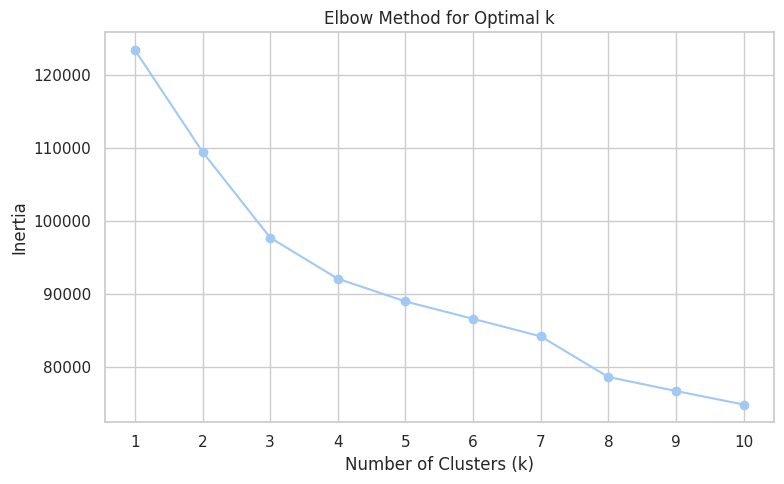


=== Running Random Forest Classifier ===
Building Random Forest Classifier for Dropout/Graduation Prediction...

Random Forest Classification Results:
Weighted F1-Score: 0.9104

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.95      0.82      0.88       284
    Graduate       0.89      0.97      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.89      0.90       726
weighted avg       0.92      0.91      0.91       726



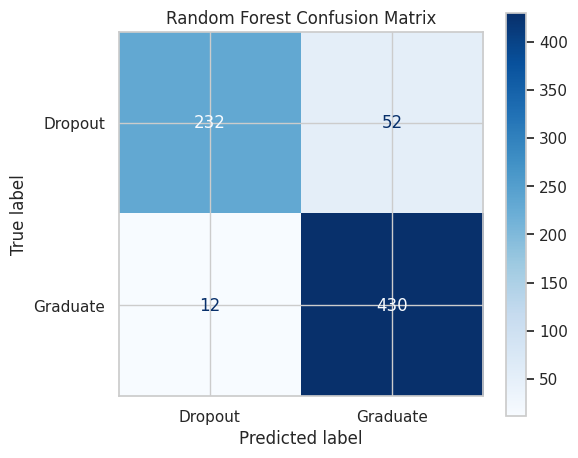


=== Running KNN Classifier ===
Building KNN Classifier for Dropout/Graduation Prediction...

KNN Classification Results:
Weighted F1-Score: 0.8399

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.91      0.67      0.77       284
    Graduate       0.82      0.96      0.88       442

    accuracy                           0.85       726
   macro avg       0.87      0.81      0.83       726
weighted avg       0.86      0.85      0.84       726



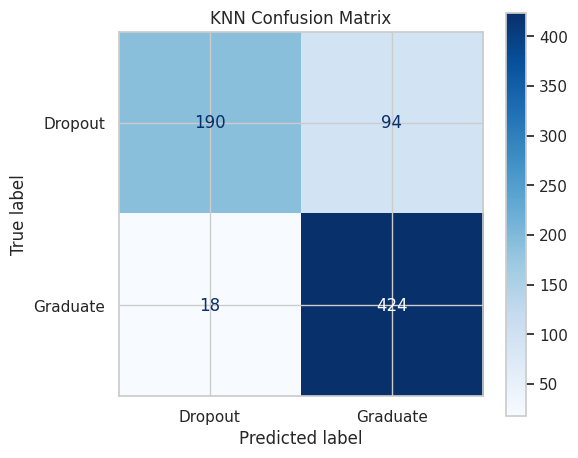


=== Running KMeans Clustering ===
Building KMeans Clustering Model for Student Data...

Clustering Results:
Number of clusters: 3

Evaluation against true labels (for reference only):
Adjusted Rand Index: 0.2911
Silhouette Score: 0.2016

Sample data with cluster labels:
   Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                      

In [ ]:
def main():
    import pandas as pd

    data_path = "dataset.csv"
    data = pd.read_csv(data_path)
    data['Target'].info()


    # Drop currently enrolled students
    if 'Target' in data.columns:
        data = data[data['Target'] != 'Enrolled']
        print(f"\nFiltered data: {len(data)} students remaining after dropping enrolled students.")
    else:
        print("\nWarning: 'status' column not found. Skipping filtering of enrolled students.")

    # gridsearch_rf_for_student_data(data)

    elbow_plot_for_kmeans(data)

    print("\n=== Running Random Forest Classifier ===")
    rf_model = build_rf_for_student_data(data)

    print("\n=== Running KNN Classifier ===")
    knn_model = build_knn_for_student_data(data)

    print("\n=== Running KMeans Clustering ===")
    kmeans_model, cluster_labels = build_kmeans_for_student_data(data, n_clusters=3)

    # Attach clustering labels to the original data for exploration (optional)
    data_with_clusters = data.copy()
    data_with_clusters['cluster'] = cluster_labels
    print("\nSample data with cluster labels:")
    print(data_with_clusters.head())

if __name__ == "__main__":
    main()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

<ipython-input-94-37c74e2f1102>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data['target_encoded'] = data['Target'].astype('category').cat.codes


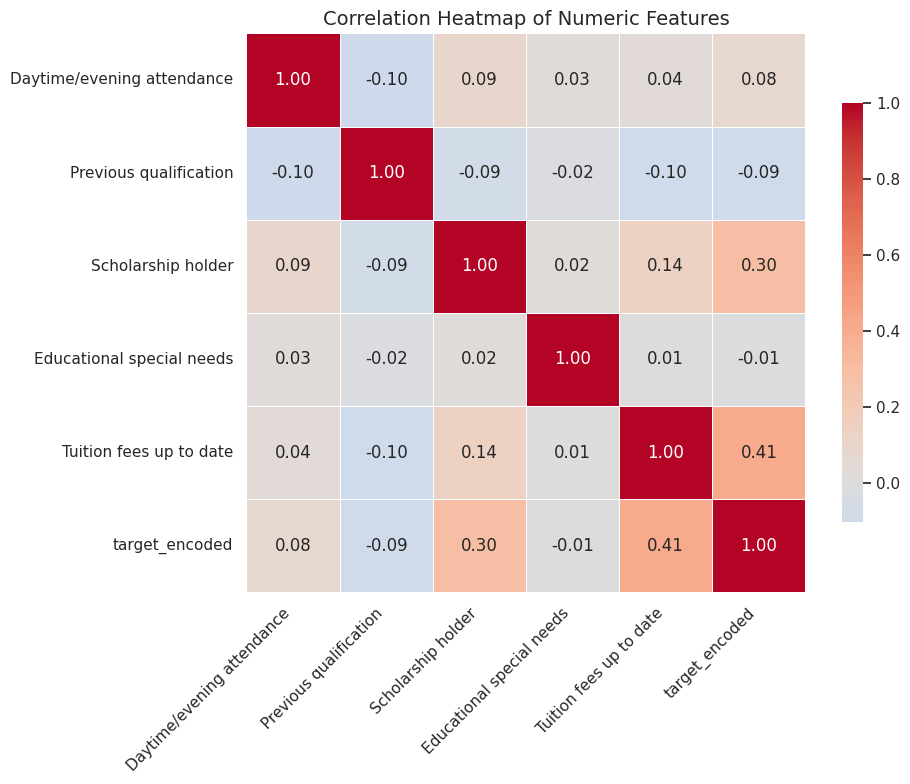

Missing column: 'gender' or 'target'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "dataset.csv"  # Update with your actual file path
data = pd.read_csv(data_path)

data.info()

def plot_correlation_heatmap(data):
    print(data.columns.tolist())

    # Select only numeric features
    numeric_data = data[['Daytime/evening attendance', 'Previous qualification', 'Scholarship holder', 'Educational special needs', 'Tuition fees up to date']]

    # Optional: convert target to numeric if it’s not
    if 'Target' in data.columns and data['Target'].dtype == 'object':
        numeric_data['target_encoded'] = data['Target'].astype('category').cat.codes

    # Compute correlation matrix
    corr_matrix = numeric_data.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .75})

    plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_correlation_heatmap(data)
plot_outcome_by_category(data)